In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from lifelines import NelsonAalenFitter
from mice_dfi import plots
from mice_dfi import dataset

## Define curve fitters

In [2]:
class SurvivalCurve(object):
    def __init__(self, **kwargs):
        self.death_journal = kwargs.get('death_journal', 0)
        self.death_times = []
        self.kaplan_meier_plot = []
        self.cohort_size = self.death_journal.shape[0]
        self.calc_survival_curve(self.death_journal)
        self.name = kwargs.get('name', 'ID not stated')
        self.fitting_interval = kwargs.get('fitting_interval', (0,200))
        self.average_lifespan = 0.
        self.maximum_lifespan = 0.
        self.calc_average_lifespan()

    def calc_survival_curve(self, death_journal):
        self.death_times = np.sort(np.unique(death_journal))
        if self.death_times[0] != 0:
            self.death_times = np.hstack((0, self.death_times))
        died = np.zeros(self.death_times.shape[0])
        for i in range(died.shape[0]):
            died[i] = np.sum(self.death_journal == self.death_times[i])
        self.kaplan_meier_plot = np.zeros(self.death_times.shape[0])
        self.kaplan_meier_plot[0] = death_journal.shape[0]
        for i in range(1, self.death_times.shape[0]):
            self.kaplan_meier_plot[i] = self.kaplan_meier_plot[i-1] - died[i-1]
        self.kaplan_meier_plot /= 1.0 * death_journal.shape[0]

    def calc_average_lifespan(self):
        idx = np.arange(self.death_times.shape[0])
        idx_next = idx[1:]
        idx_prev = idx[:-1]
        self.average_lifespan = (np.sum((self.death_times[idx_next] - self.death_times[idx_prev]) * self.kaplan_meier_plot[idx_next]) +
                                 1./2 * (self.death_times[-1] - self.death_times[-2]) * self.kaplan_meier_plot[-1])

    def reshuffle_data(self, train_size=0.7):
        dj = []
        unique_deaths = np.unique(self.death_journal)
        for year in unique_deaths:
            idx = (self.death_journal == year)
            num = np.sum(idx)
            # 1% error
            new_num = num * (0.9 + 0.20 * np.random.rand())
            if new_num < 0:
                new_num = 0
            if len(dj) + new_num > self.death_journal.shape[0]:
                dj += [year] * int(self.death_journal.shape[0] - len(dj))
                break
            else:
                dj += [year] * int(new_num)
        dj = np.array(dj)
        self.calc_survival_curve(dj)
        self.calc_average_lifespan()

    def fit_mortality(self, func, bounds=(1e-12,[30., 30.]), p0=(1e-3,1.)):
        
        idx_interval = np.logical_and(self.death_times > self.fitting_interval[0],
                                      self.death_times < self.fitting_interval[1])
        
        res_opt, _ = curve_fit(func, self.death_times[idx_interval], self.kaplan_meier_plot[idx_interval],
						bounds=bounds, p0=p0, maxfev=10000, xtol=1e-10, ftol=1e-10, gtol=1e-10)
        self.calc_survival_curve(self.death_journal)
        return res_opt

    def calc_mean_parameters(self, M0s, alphas):
        return np.mean(M0s), np.std(M0s), np.mean(alphas), np.std(alphas)

class GompertzFit(SurvivalCurve):
    def __init__(self, **kwargs):
        SurvivalCurve.__init__(self, **kwargs)
        self.alpha = 0.1
        self.M0 = 0.01
        self.M0_std = 0
        self.alpha_std = 0
        self.lifespan = 0
        self.lifespan_std = 0
        self.M0s = []
        self.alphas = []
        self.av_lfses = []

    def Gompertz(self, t, M0, alpha):
        return np.exp(1.0*M0/alpha * (1 - np.exp(alpha * t)))

    def raw_mortality(self):
        y = -np.log(self.kaplan_meier_plot.copy())
        x = self.death_times.copy()
        margin = 20
        t = x[margin:-margin]
        der = (y[2 * margin:] - y[:-2 * margin]) / (t[margin] - t[0])
        return t, der

    def fit_Gompertz(self, bounds=(0.,[30.,30.]), p0=([0.1,0.1])):
        for i in range(200):
            self.reshuffle_data()
            res_opt = self.fit_mortality(self.Gompertz, bounds=bounds, p0=p0)
            self.M0s.append(res_opt[0])
            self.alphas.append(res_opt[1])
        self.M0, self.M0_std, self.alpha, self.alpha_std = self.calc_mean_parameters(self.M0s, self.alphas)
        self.GompertzCurves = [self.Gompertz(self.death_times, self.M0, self.alpha),
                               self.Gompertz(self.death_times, self.M0 + self.M0_std, self.alpha - self.alpha_std),
                               self.Gompertz(self.death_times, self.M0 - self.M0_std, self.alpha + self.alpha_std)]



## Load mortality data

In [3]:
data = dataset.load_lifespan_itp()

Total files: 11
Total # of animals: 22276
# of controls: 6628
# of controls with known lifespan: 6227


## Fit data and plot

In [4]:
fileformat_ = 'svg'
os.makedirs('./figs',exist_ok=True)  # saving pngs
os.makedirs('./source',exist_ok=True)  # saving source data
bbox_inches = None # None  or 'tight'
production = True
plots.set_style(production=production)
cm = 1/2.54  # centimeters in inches
dpi=300
if production:
    fig_size = 8.8 * cm
    fontsize = 7
    scale=0.5
else:
    fig_size = 18. * cm
    fontsize = 12
    scale= 1
    # fileformat_ = 'png'

Sex: m
Gompertz alpha 0.03850052763303713 +/- 0.00024402102656909157
Gompertz M0 0.00041291488885655136 +/- 7.193811131119987e-06
Aver ls: 100.09204498125781


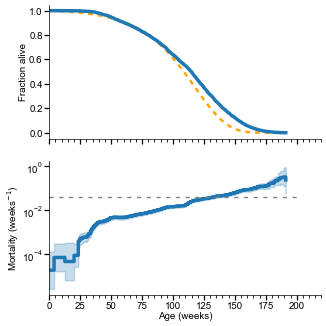

Sex: f
Gompertz alpha 0.05679403492744111 +/- 0.000389448043665965
Gompertz M0 3.394239297693291e-05 +/- 1.2211519340089955e-06
Aver ls: 117.95892031697115


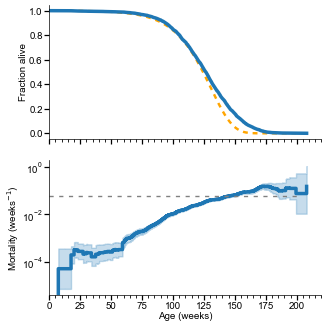

In [5]:
figsize=(fig_size, fig_size)
# figsize=(4.167, 3.490)
sexes = ['m', 'f']
is_suppl = [True, False]
kmps = {}
bandwidth = 5
for sex, suppl in zip(sexes, is_suppl):
    if suppl:
        suppl_str = 'suppl_'
        fileformat = 'png'
    else:
        suppl_str = ''
        fileformat = fileformat_
    data_i = data[data.sex == sex].copy()
    death_journal = np.sort(data_i['age'].values)
    fitint = (0, 220)
    kmp = GompertzFit(death_journal=death_journal, name='Sex: {}'.format(sex),
                      fitting_interval=fitint
                     )
    kmp.fit_Gompertz(p0=(1e-8, 0.2))
    kmp.calc_survival_curve(kmp.death_journal)
    kmps[sex] = kmp
    print("Sex: {}".format(sex))
    print("Gompertz alpha {} +/- {}".format(kmp.alpha, kmp.alpha_std))
    print("Gompertz M0 {} +/- {}".format(kmp.M0, kmp.M0_std))
    print("Aver ls:", kmp.average_lifespan)

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(*figsize)
    # survival curves
    gompertz_fit = kmp.Gompertz(kmp.death_times, kmp.M0, kmp.alpha)
    ax1.plot(kmp.death_times, gompertz_fit,
             color='orange', linestyle='dashed', dashes=(2,2), lw=3.5*scale)
    ax1.plot(kmp.death_times, kmp.kaplan_meier_plot, lw=5*scale)
    ax1.set_ylabel('Fraction alive', fontsize=fontsize)

    # Save data source for NC submission
    source = pd.DataFrame(data=np.column_stack((kmp.death_times, kmp.kaplan_meier_plot, gompertz_fit)), columns=['Age (weeks)', 'survival', 'gompertz_fit'])
    try:
        with pd.ExcelWriter('./source/{:s}fig4_mortality_deceleration.xlsx'.format(suppl_str), engine="openpyxl",  mode="a", if_sheet_exists="replace") as writer:
            source.to_excel(writer, sheet_name='survival_curve_{:s}'.format(sex))
    except FileNotFoundError:
        with pd.ExcelWriter('./source/{:s}fig4_mortality_deceleration.xlsx'.format(suppl_str), engine="openpyxl") as writer:
            source.to_excel(writer, sheet_name='survival_curve_{:s}'.format(sex))

    # empirical mortality curves
    kmf = NelsonAalenFitter(nelson_aalen_smoothing=True)
    kmf.fit(death_journal)
    alpha = kmp.alpha
    M0 = kmp.M0
    kmf.plot_hazard(bandwidth=bandwidth, lw=5*scale, legend=None, ax=ax2)
    ax2.plot([0,200], [alpha, alpha], lw = 2*scale, color='grey', linestyle='dashed', dashes=(3,4))
    ax2.set_yscale('log')
    ax2.set_xlim([0,220])
    ax2.set_xlabel('Age (weeks)', fontsize=fontsize)
    ax2.set_ylabel(r'Mortality (weeks$^{-1}$)', fontsize=fontsize)
    # ax1.annotate('a', (0.05,1.05), xycoords='axes fraction', fontsize=fontsize)
    # ax2.annotate('b', (0.05,1.1), xycoords='axes fraction', fontsize=fontsize)

    fig.tight_layout()
    fig.savefig('./figs/{:s}fig4_mortality_{:s}.{:s}'.format(suppl_str, sex, fileformat),  dpi=300, bbox_inches=bbox_inches, pad_inches=0)
    plt.show()

    # Save data source for NC submission
    source = pd.concat((kmf.smoothed_hazard_(bandwidth), kmf.confidence_interval_), axis=1).reset_index()
    source.columns = ['Age (weeks)', 'Mortality (week^-1)', 'Mortality (week^-1)_CI_lower_0.95', 'Mortality (week^-1)_CI_upper_0.95',]
    try:
        with pd.ExcelWriter('./source/{:s}fig4_mortality_deceleration.xlsx'.format(suppl_str), engine="openpyxl",  mode="a", if_sheet_exists="replace") as writer:
            source.to_excel(writer, sheet_name='empirical_mortality_{:s}'.format(sex), )
    except FileNotFoundError:
        with pd.ExcelWriter('./source/{:s}fig4_mortality_deceleration.xlsx'.format(suppl_str), engine="openpyxl") as writer:
            source.to_excel(writer, sheet_name='empirical_mortality_{:s}'.format(sex))
